# IBM Data Science Capstone Project

**The project works on the neighbourhoods and boroughs in New York City and looking to solve the problem of selecting an appropriate neighbourhood for opening a japanese/sushi restaurantt.**

I used word clouds on the cuisine data of NYC obtained from wikipedia to understand the spread of cuisines. I utilized the results of the word cloud to select a location in NYC and implemented K-means clustering in that region to pick the best neighbourhood to open the restaurant.  

In [2]:
#Importing the required libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from PIL import Image # converting images into arrays

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

In [3]:
#Downloading and importing the word cloud library
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

     |████████████████████████████████| 368kB 5.5MB/s eta 0:00:01


## Exploring the cuisine dataset
This block might look weired because i'm using ibm watson studio where i also stored the restaurant grades 

In [23]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_7fc95c1a32534a3294a78075be4c2b66 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fFbiiG2fM5_z4G2JSmuzdYZulW_VhRWAVxY8yjCfIvyk',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_7fc95c1a32534a3294a78075be4c2b66.get_object(Bucket='clusteringdemo-donotdelete-pr-xrdp4uzmrncpon',Key='Restaurant_Grades.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cuisine = pd.read_csv(body)
cuisine.head()


,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE
0,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,Bakery,Pesticide use not in accordance with label or ...,N,6,A,06/11/2019,08/13/2019
1,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,Bakery,Plumbing not properly installed or maintained;...,N,6,A,06/11/2019,08/13/2019
2,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,Bakery,Non-food contact surface improperly constructe...,N,6,A,06/11/2019,08/13/2019
3,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,Bakery,Pesticide use not in accordance with label or ...,N,5,A,05/11/2018,08/13/2019
4,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,Bakery,Non-food contact surface improperly constructe...,N,5,A,05/11/2018,08/13/2019


In [24]:
bor_cuisine=cuisine[['BORO', 'CUISINE DESCRIPTION']]
bor_cuisine.head()

,BORO,CUISINE DESCRIPTION
0,Bronx,Bakery
1,Bronx,Bakery
2,Bronx,Bakery
3,Bronx,Bakery
4,Bronx,Bakery


In [25]:
bor_cuisine['BORO'].value_counts()

Manhattan        76389
Brooklyn         48689
Queens           44702
Bronx            18154
Staten Island     6675
0                   54
Name: BORO, dtype: int64

In [26]:
bor_cuisine['CUISINE DESCRIPTION'].value_counts()

American                                                            43124
Chinese                                                             19892
Café/Coffee/Tea                                                     10510
Pizza                                                                8712
Italian                                                              7787
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     7687
Mexican                                                              7540
Japanese                                                             6637
Bakery                                                               6199
Caribbean                                                            6180
Spanish                                                              5493
Pizza/Italian                                                        4081
Chicken                                                              3704
Donuts                                

#### Exploring cuisines in Manhattan

In [27]:
Man_cuisine=bor_cuisine[bor_cuisine['BORO'] == 'Manhattan']
Cuisine_M=Man_cuisine[['CUISINE DESCRIPTION']]
Cuisine_M.head()

,CUISINE DESCRIPTION
21,Irish
22,Irish
23,Irish
24,Irish
25,Irish


In [28]:
Cuisine_M.to_csv('CUISINE_M.txt', sep=',', index=False)
Cuisine_M1 = open('CUISINE_M.txt', 'r').read()
stopwords = set(STOPWORDS)
NYC_CUISINE_Man = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_Man.generate(Cuisine_M1)

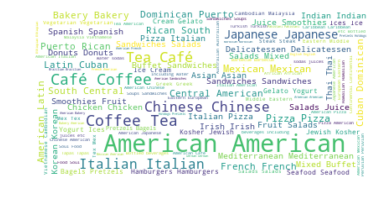

<Figure size 3240x3960 with 0 Axes>

In [29]:
plt.imshow(NYC_CUISINE_Man, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(45)
fig.set_figheight(55)

plt.show()

#### Exploring cuisines in Brooklyn 

In [30]:
Brook_cuisine=bor_cuisine[bor_cuisine['BORO'] == 'Brooklyn']
Cuisine_B=Brook_cuisine[['CUISINE DESCRIPTION']]
Cuisine_B.head()

,CUISINE DESCRIPTION
7,Hamburgers
8,Hamburgers
9,Hamburgers
10,Hamburgers
11,Hamburgers


In [31]:
Cuisine_B.to_csv('CUISINE_B.txt', sep=',', index=False)
Cuisine_B1 = open('CUISINE_B.txt', 'r').read()
NYC_CUISINE_B = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_B.generate(Cuisine_B1)

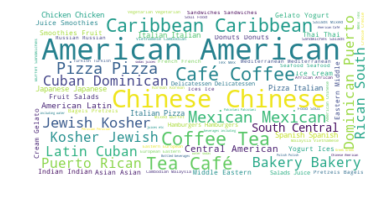

<Figure size 3240x3960 with 0 Axes>

In [32]:
plt.imshow(NYC_CUISINE_B, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(45)
fig.set_figheight(55)

plt.show()

#### Exploring cuisines in Bronx

In [33]:
Bronx_cuisine=bor_cuisine[bor_cuisine['BORO'] == 'Bronx']
Cuisine_Br=Bronx_cuisine[['CUISINE DESCRIPTION']]
Cuisine_Br.head()

,CUISINE DESCRIPTION
0,Bakery
1,Bakery
2,Bakery
3,Bakery
4,Bakery


In [34]:
Cuisine_Br.to_csv('CUISINE_Br.txt', sep=',', index=False)
Cuisine_Br1 = open('CUISINE_Br.txt', 'r').read()

NYC_CUISINE_Br = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_Br.generate(Cuisine_Br1)

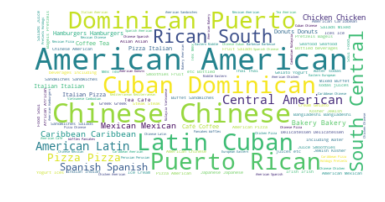

<Figure size 3240x3960 with 0 Axes>

In [35]:
plt.imshow(NYC_CUISINE_Br, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(45)
fig.set_figheight(55)

plt.show()

#### Exploring cuisines on Staten Island

In [36]:
staten_island_cuisine=bor_cuisine[bor_cuisine['BORO'] == 'Staten Island']
Cuisine_stat=staten_island_cuisine[['CUISINE DESCRIPTION']]
Cuisine_stat.head()

,CUISINE DESCRIPTION
201,Delicatessen
202,Delicatessen
203,Delicatessen
204,Delicatessen
205,Delicatessen


In [37]:
Cuisine_stat.to_csv('CUISINE_stat.txt', sep=',', index=False)
Cuisine_stat1 = open('CUISINE_stat.txt', 'r').read()

NYC_CUISINE_stat = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_stat.generate(Cuisine_stat1)

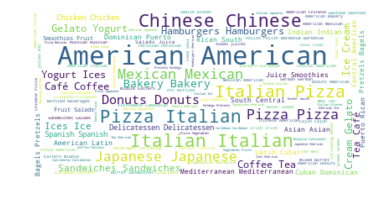

<Figure size 3240x3960 with 0 Axes>

In [38]:
plt.imshow(NYC_CUISINE_stat, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(45)
fig.set_figheight(55)

plt.show()

In [39]:
bor_japanese=bor_cuisine[bor_cuisine['CUISINE DESCRIPTION'] == 'Japanese']
bor_japanese['BORO'].value_counts()


Manhattan        3603
Brooklyn         1405
Queens           1185
Staten Island     291
Bronx             153
Name: BORO, dtype: int64

**The above word clouds show that the most popular cuisine in New York in American. In case of Japanese cuisine, Manhattan has more Japanese restaurants than any other city in the NYC region. Thus, exploring Manhattan makes sense.**


In [42]:
body = client_7fc95c1a32534a3294a78075be4c2b66.get_object(Bucket='clusteringdemo-donotdelete-pr-xrdp4uzmrncpon',Key='newyork_data.json')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object 

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face an error during data loading.
# Please read the documentation of 'pandas.read_json()' and 'pandas.io.json.json_normalize' to learn more about the possibilities to adjust the data loading.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-reader
# and http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html

# df_data_1 = pd.read_json(body, orient='values')
# df_data_1.head()
newyork_data = json.load(body)

In [43]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [44]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [45]:
#Creating an empty dataframe for NYC
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiating the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [46]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [47]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [48]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [49]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [50]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [51]:
# creating map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [52]:
CLIENT_ID = 'G4I3D3YSAMSFMPKSBG2BFDJAINTYF1PWIYFMADGVEMCKOUCO' # your Foursquare ID
CLIENT_SECRET = '5YZVUGXI4E1BCZQF0TZDIKRXPNSVAT0N5C1WRBPSJ10AJ4ZL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G4I3D3YSAMSFMPKSBG2BFDJAINTYF1PWIYFMADGVEMCKOUCO
CLIENT_SECRET:5YZVUGXI4E1BCZQF0TZDIKRXPNSVAT0N5C1WRBPSJ10AJ4ZL


### Exploring Manhattan borough for clustering 

In [53]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [54]:
dress = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bronx are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bronx are 40.7127281, -74.0060152.


In [56]:
# creating map of Bronx using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [57]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [58]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


In [59]:
LIMIT=100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=G4I3D3YSAMSFMPKSBG2BFDJAINTYF1PWIYFMADGVEMCKOUCO&client_secret=5YZVUGXI4E1BCZQF0TZDIKRXPNSVAT0N5C1WRBPSJ10AJ4ZL&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

In [60]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9437040de0d90023e3e494'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 25,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

In [61]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [62]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filtering columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filtering the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# cleaning columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Dunkin',Donut Shop,40.877136,-73.906666
4,Starbucks,Coffee Shop,40.877531,-73.905582


In [63]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


In [64]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # returning only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [67]:
manhattan_venues=getNearbyVenues(names=manhattan_data['Neighborhood'],
                                    latitudes=manhattan_data['Latitude'],
                                    longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [68]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3176, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [69]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,70,70,70,70,70,70
Carnegie Hill,90,90,90,90,90,90
Central Harlem,41,41,41,41,41,41
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,41,41,41,41,41,41
East Village,100,100,100,100,100,100


In [70]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 329 uniques categories.


In [71]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop

In [72]:
manhattan_onehot.shape

(3176, 330)

In [73]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop

In [74]:
manhattan_grouped.shape

(40, 330)

In [75]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.07
2            Gym  0.06
3  Memorial Site  0.04
4    Coffee Shop  0.04


----Carnegie Hill----
                  venue  freq
0           Coffee Shop  0.08
1                  Café  0.06
2        Cosmetics Shop  0.03
3             Bookstore  0.03
4  Gym / Fitness Center  0.03


----Central Harlem----
                 venue  freq
0    French Restaurant  0.05
1   African Restaurant  0.05
2  American Restaurant  0.05
3                  Bar  0.05
4   Chinese Restaurant  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.05
2   Italian Restaurant  0.04
3  American Restaurant  0.04
4       Ice Cream Shop  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.09
1         Cocktail Bar  0.05
2  American Restaurant  0.04
3               Bakery  0.04
4         Dessert Shop  0.03


----Civic Center----
               venue  fr

In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# creating a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Coffee Shop,Memorial Site,Wine Shop,Gourmet Shop,Mexican Restaurant,Shopping Mall
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Gym,Pizza Place,Bookstore,Bakery,Japanese Restaurant,Cosmetics Shop,Italian Restaurant
2,Central Harlem,Seafood Restaurant,Bar,African Restaurant,American Restaurant,Chinese Restaurant,French Restaurant,Dessert Shop,Library,Gym / Fitness Center,Beer Bar
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Ice Cream Shop,Bakery,Gym / Fitness Center,Speakeasy,Hotel,Nightclub
4,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Spa,Dessert Shop,Salon / Barbershop,Vietnamese Restaurant,Hotpot Restaurant,Optical Shop


In [78]:
# setting number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 4, 0, 1, 4, 1, 1], dtype=int32)

In [79]:
# adding clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merging toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # checking the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Spa,Dessert Shop,Salon / Barbershop,Vietnamese Restaurant,Hotpot Restaurant,Optical Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Grocery Store,Deli / Bodega,Chinese Restaurant,Mobile Phone Shop,Mexican Restaurant,Supplement Shop,Coffee Shop,Latin American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Café,Lounge,Pizza Place,Restaurant,Chinese Restaurant,Park,Bakery,American Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Cocktail Bar,Sandwich Place,Bakery,Yoga Studio


In [80]:
# creating map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [81]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,Seafood Restaurant,Bar,African Restaurant,American Restaurant,Chinese Restaurant,French Restaurant,Dessert Shop,Library,Gym / Fitness Center,Beer Bar
13,Lincoln Square,Plaza,Café,Italian Restaurant,Performing Arts Venue,Theater,Concert Hall,Wine Shop,American Restaurant,Gym / Fitness Center,Indie Movie Theater
21,Tribeca,Italian Restaurant,Park,Café,Spa,Wine Bar,Coffee Shop,American Restaurant,Men's Store,Burger Joint,Skate Park
24,West Village,Italian Restaurant,New American Restaurant,Wine Bar,American Restaurant,Bakery,Park,Cocktail Bar,Jazz Club,Gastropub,Coffee Shop
26,Morningside Heights,Park,Bookstore,Coffee Shop,American Restaurant,Deli / Bodega,Burger Joint,New American Restaurant,Outdoor Sculpture,Grocery Store,Greek Restaurant
28,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Coffee Shop,Memorial Site,Wine Shop,Gourmet Shop,Mexican Restaurant,Shopping Mall
32,Civic Center,Coffee Shop,French Restaurant,Hotel,Cocktail Bar,Yoga Studio,Park,Spa,Sushi Restaurant,American Restaurant,Gym / Fitness Center
35,Turtle Bay,Italian Restaurant,Coffee Shop,Hotel,Café,Sushi Restaurant,Japanese Restaurant,French Restaurant,Deli / Bodega,Park,Wine Bar
39,Hudson Yards,American Restaurant,Hotel,Gym / Fitness Center,Italian Restaurant,Dog Run,Spanish Restaurant,Burger Joint,Café,Thai Restaurant,Gym


In [82]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center,Exhibit,Yoga Studio,Wine Shop,Juice Bar,French Restaurant,Spa
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Pizza Place,Sushi Restaurant,Wine Shop,Diner,Japanese Restaurant
10,Lenox Hill,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Cocktail Bar,Café,Burger Joint,Gym,Gym / Fitness Center,Playground
12,Upper West Side,Italian Restaurant,Bakery,Bar,Coffee Shop,Thai Restaurant,Shoe Store,Seafood Restaurant,Café,Bagel Shop,Ice Cream Shop
14,Clinton,Italian Restaurant,Gym / Fitness Center,Theater,Coffee Shop,Spa,Thai Restaurant,Cocktail Bar,Sandwich Place,Gym,Hotel
15,Midtown,Coffee Shop,Hotel,Theater,Sandwich Place,Sporting Goods Shop,Steakhouse,Gym,Clothing Store,Café,Bakery
16,Murray Hill,Sandwich Place,Hotel,Bar,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Pizza Place,Burger Joint,Gym / Fitness Center,Mediterranean Restaurant
17,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Ice Cream Shop,Bakery,Gym / Fitness Center,Speakeasy,Hotel,Nightclub
18,Greenwich Village,Italian Restaurant,Café,French Restaurant,Sushi Restaurant,Gym,Dessert Shop,Coffee Shop,Chinese Restaurant,Sandwich Place,Pilates Studio
19,East Village,Bar,Pizza Place,Ice Cream Shop,Mexican Restaurant,Wine Bar,Coffee Shop,Cocktail Bar,Speakeasy,Ramen Restaurant,Korean Restaurant


In [83]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Boat or Ferry,Park,Bar,Gas Station,Baseball Field,Harbor / Marina,German Restaurant,Cocktail Bar,Coffee Shop,Heliport


In [84]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place


In [86]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Spa,Dessert Shop,Salon / Barbershop,Vietnamese Restaurant,Hotpot Restaurant,Optical Shop
2,Washington Heights,Café,Bakery,Grocery Store,Deli / Bodega,Chinese Restaurant,Mobile Phone Shop,Mexican Restaurant,Supplement Shop,Coffee Shop,Latin American Restaurant
3,Inwood,Mexican Restaurant,Café,Lounge,Pizza Place,Restaurant,Chinese Restaurant,Park,Bakery,American Restaurant,Frozen Yogurt Shop
4,Hamilton Heights,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Cocktail Bar,Sandwich Place,Bakery,Yoga Studio
5,Manhattanville,Coffee Shop,Seafood Restaurant,Italian Restaurant,Park,Mexican Restaurant,Chinese Restaurant,Spanish Restaurant,Check Cashing Service,Bank,Bar
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Thai Restaurant,Latin American Restaurant,Convenience Store,Spanish Restaurant,Liquor Store,Gas Station,Taco Place
11,Roosevelt Island,Pizza Place,Park,Gym,Coffee Shop,Kosher Restaurant,Greek Restaurant,Dog Run,Liquor Store,Sandwich Place,Scenic Lookout
20,Lower East Side,Chinese Restaurant,Café,Bakery,Japanese Restaurant,Coffee Shop,Park,Ramen Restaurant,Art Gallery,Pizza Place,Filipino Restaurant
25,Manhattan Valley,Coffee Shop,Mexican Restaurant,Indian Restaurant,Bar,Yoga Studio,Pizza Place,Thai Restaurant,Chinese Restaurant,Clothing Store,Ethiopian Restaurant
36,Tudor City,Park,Café,Greek Restaurant,Mexican Restaurant,Deli / Bodega,Diner,Coffee Shop,Gym / Fitness Center,Restaurant,Garden


In [87]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [110]:
restaurants_neighborhood=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


In [111]:
type(restaurants_neighborhood)

pandas.core.frame.DataFrame

In [113]:
df=restaurants_neighborhood[restaurants_neighborhood['3rd Most Common Venue'] == 'Japanese Restaurant']
df

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,Burger Joint,Clothing Store,American Restaurant,Gym / Fitness Center,Coffee Shop,Salad Place
38,Flatiron,New American Restaurant,Gym / Fitness Center,Japanese Restaurant,Italian Restaurant,American Restaurant,Furniture / Home Store,Café,Cycle Studio,Spa,Vegetarian / Vegan Restaurant


**Most of the restaurants could be found in cluster 1 and cluster 4. However, in  both clusters, there weren't any japanese/sushi  restaurants which were the first most common venue. In cluster 1 however, in Midtown South and Flatiron neighborhoods, Japanese Restaurants is the 3rd most common venue and this tells us that japanese food is prominent in this area. Thus, opening up a restaurant in this neighborhood would be a profitable choice** 